In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [3]:
# Load the data
nordpool = pd.read_csv('New Data/2021/Nordpool DKK.csv')
energinet = pd.read_csv('New Data/2021/Energinet DKK.csv')
weather_observation = pd.read_csv('New Data/2021/Weather Observation.csv')
weather_forecast = pd.read_csv('New Data/2021/Weather Forecast.csv')
network = pd.read_csv('New Data/2021/Network Manager.csv')

# Filter energinet price area
energinet = energinet[energinet['PriceArea | PriceArea | 804696'] == 'DK2']
# Drop price area
energinet.drop('PriceArea | PriceArea | 804696', axis=1, inplace=True)

# Convert ts to datetime
nordpool['ts'] = pd.to_datetime(nordpool['ts'])
energinet['ts'] = pd.to_datetime(energinet['ts'])
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'])
weather_forecast['ts'] = pd.to_datetime(weather_forecast['ts'])
network['ts'] = pd.to_datetime(network['ts'])

# Resample network_manager data to hourly intervals (average the data)
network = network.set_index('ts')
network = network.resample('h').mean()
network.reset_index(inplace=True)

## Step 2: Data Handling

In [4]:
# Compare length of dfs + get first & last timestamp
def get_first_last(**dfs):
    # Initialize
    first_last = pd.DataFrame(index=['first', 'last', 'length', 'start_check', 'end_check'])
    col_name='ts'
    # Save first and last timestamp for each dataframe
    for name, df in dfs.items():
        first_ts = df['ts'].iloc[0]
        last_ts = df['ts'].iloc[-1]
        start_check = start == first_ts
        end_check = end == last_ts
        first_last[name] = [first_ts, last_ts, len(df), start_check, end_check]
    return first_last

# Initialize
start = pd.to_datetime('2021-01-01 00:00:00')
end = pd.to_datetime('2021-12-31 23:00:00')

print("Length of a year in hours:", 365*24)
get_first_last(nordpool=nordpool, energinet=energinet, weather_observation=weather_observation, weather_forecast=weather_forecast, network=network)

Length of a year in hours: 8760


,nordpool,energinet,weather_observation,weather_forecast,network
first,2021-01-02 00:00:00,2021-01-01 00:00:00,2021-01-15 16:00:00,2021-01-01 00:00:00,2021-01-01 00:00:00
last,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-29 11:00:00,2021-12-31 23:00:00
length,8735,8759,7936,8694,8760
start_check,False,True,False,True,True
end_check,True,True,True,False,True


### Data Merging

In [5]:
# Merge the dataframes on network with left join
data = pd.merge(network, weather_forecast, on='ts', how='left')
data = pd.merge(data, weather_observation, on='ts', how='left') 

# Sort the data by the timestamp column 'ts' to ensure time order
data21 = data.sort_values(by='ts')

# Save to csv
# data21.to_csv('New Data/2021/Wind Data 21.csv', index=False)

data21.head()

,ts,Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133,Hasle Vind Active Power | has_vin_effekt | 804123,Hasle Vind Current | has_vin_belastning | 804117,Weather forecast for the max air temperature for the coming 6 hours at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_max | 128206,Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270,Weather forecast for the precipitation amount for the coming 1 hour at Bornholm | 9F7P/00/00/MET-Norway/forecast/precipitation_amount_acc | 128238,Weather forecast for the relativehumidity amount at Bornholm | 9F7P/00/00/MET-Norway/forecast/relative_humidity_2m | 128254,Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286,Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318,...,Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302,Weather forecast for the air temperature at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_2m | 128190,Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592,Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672,Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608,Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640,Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576,Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560,Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624,Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656
0,2021-01-01 00:00:00,10.505372,0.310046,19.138536,275.52020,189.13286,0.000000,0.848557,3.711973,3.658367,...,0.593647,275.51404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,10.499852,0.739963,42.792531,275.50630,191.73468,0.269043,0.937904,3.358219,3.176009,...,0.794102,275.36557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,10.440138,0.877331,50.523536,275.13600,184.39082,0.167969,0.974747,3.255157,3.315285,...,0.328136,275.08374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,10.423414,0.842384,47.936477,274.88626,178.39856,0.000000,0.973976,3.109769,3.461883,...,-0.328434,274.86594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,10.401766,0.469178,28.816449,274.93670,170.38286,0.662842,0.989250,3.090981,3.048118,...,-0.469315,274.80240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load merged data from 2022  (neccessary for feature engineering like lags)

In [16]:
# Load csv
data22 = pd.read_csv('New Data/2022/Wind Data 22.csv')

# Concatenate the dataframes
data = pd.concat([data21, data22], join='inner', axis=0, ignore_index=True)

# Ensure datetime format
data['ts'] = pd.to_datetime(data['ts'])

Column cleaning

In [17]:

# Use regex to remove everything starting from '|'
data.columns = data.columns.str.replace(r'\|.*', '', regex=True)
nordpool.columns = nordpool.columns.str.replace(r'\|.*', '', regex=True)
energinet.columns = energinet.columns.str.replace(r'\|.*', '', regex=True)

# Use regex to remove everything starting from the word "at"
data.columns = data.columns.str.replace(r'\sat.*', '', regex=True)
data.columns = data.columns.str.replace(r'Hasle', '', regex=True)
data.columns = data.columns.str.replace(r'Vind', 'Wind', regex=True)

# Strip columns
data.columns = data.columns.str.strip()

data.columns

Index(['ts', 'Common 10kV Lines Voltage', 'Wind Active Power', 'Wind Current',
       'Weather forecast for the max air temperature for the coming 6 hours',
       'Weather forecast for wind direction',
       'Weather forecast for the precipitation amount for the coming 1 hour',
       'Weather forecast for the relativehumidity amount',
       'Weather forecast for wind speed',
       'Weather forecast for wind speed y_direction',
       'Weather forecast for solar shortwave flux',
       'Weather forecast for the minimum air temperature for the coming 6 hours',
       'Weather forecast for wind speed x_direction',
       'Weather forecast for the air temperature',
       'Observed maximum temperature past hour',
       'Observed mean intensity of global radiation in the latest hour',
       'Observed minimum temperature past hour',
       'Observed mean wind speed the past hour',
       'Observed mean humidity past hour',
       'Observed mean temperature past hour',
       'Observed

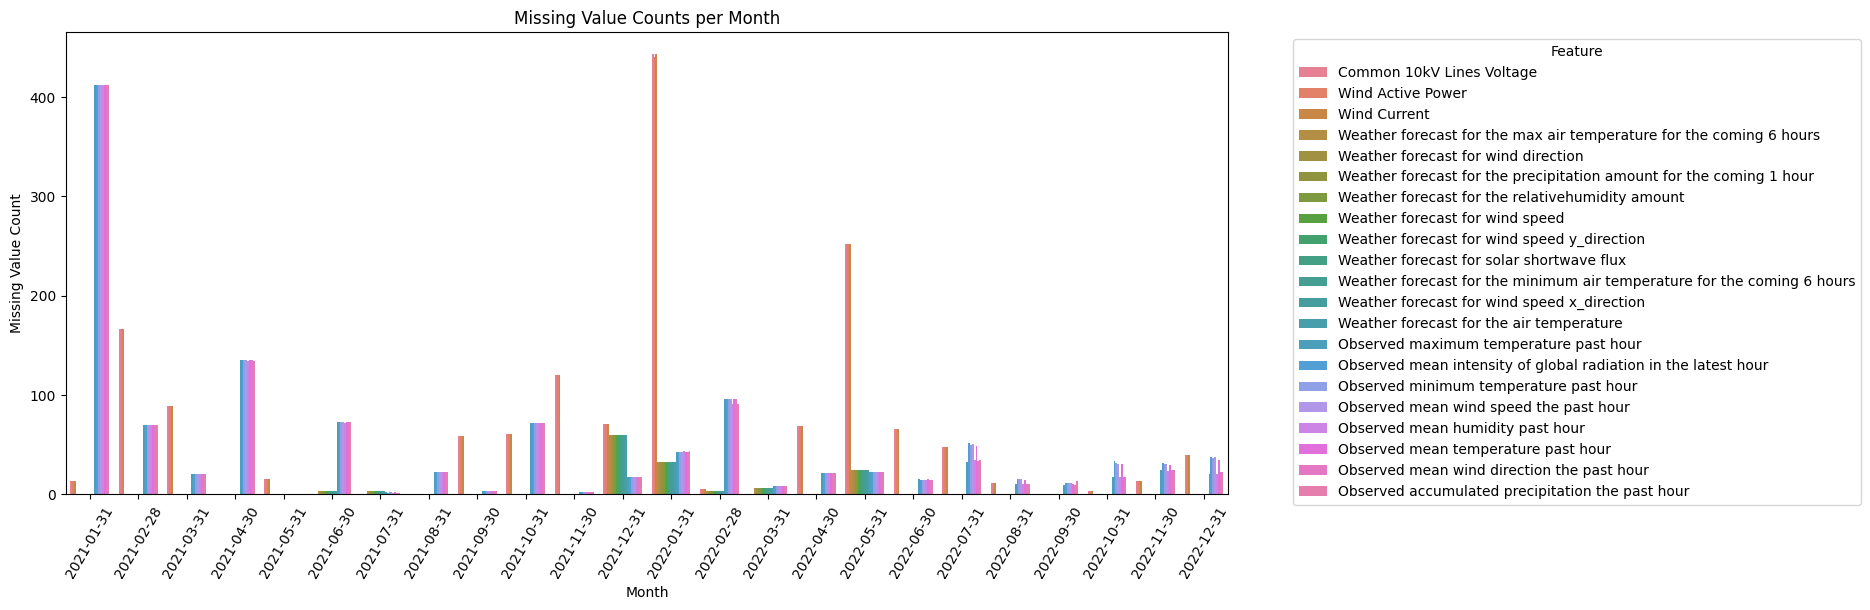

In [8]:
# Resample the data by months ('M') and count missing values for each period
data = data.set_index('ts')
missing_per_month = data.isnull().resample('ME').sum()
# Reset
data = data.reset_index()

# Convert the resampled data into a long-form dataframe for easier plotting with Seaborn
missing_per_month_long = missing_per_month.reset_index().melt(id_vars='ts', var_name='Feature', value_name='Missing Count')

# Create the seaborn barplot
plt.figure(figsize=(15, 6))
sns.barplot(x='ts', y='Missing Count', hue='Feature', data=missing_per_month_long)
plt.xticks(rotation=60)
plt.title('Missing Value Counts per Month')
plt.xlabel('Month')
plt.ylabel('Missing Value Count')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Missing Values Handling

In [18]:
# df_interpolated = data.interpolate(method='linear')

# Set ts as index
missing_before = data.isnull().sum()
data = data.set_index('ts')
# Interpolate missing values (time series-based)
data = data.interpolate(method='time')
# Reset index
data = data.reset_index()
missing_after = data.isnull().sum()

missing_summary = pd.DataFrame({'Before': missing_before, 'After': missing_after})
missing_summary

,Before,After
ts,0,0
Common 10kV Lines Voltage,1544,0
Wind Active Power,1541,0
Wind Current,1544,0
Weather forecast for the max air temperature for the coming 6 hours,132,0
Weather forecast for wind direction,132,0
Weather forecast for the precipitation amount for the coming 1 hour,132,0
Weather forecast for the relativehumidity amount,132,0
Weather forecast for wind speed,132,0
Weather forecast for wind speed y_direction,132,0


Features for Weather observation can not be interpolated as they occur in the very beginning. (01/01/21 - 15/01/21)

### Feature Engineering

- Lagged days
- Quantiles from prev week
- Wind power production is proportional to the cube of the wind speed: $P = \frac{1}{2} \rho \pi r^2 V^3 $
- Time-based features like day and hour


Since 'Observed mean wind speed the past hour' and 'Observed Wind Speed Cubed' are highly correlated, we may encounter multicollinearity which can inflate variance estimates for regression coefficients. 

-> Lasso or Ridge regression or Nonlinear Regression needed?


In [19]:
data = data.rename(columns={'Wind Active Power': 'Wind Power'})

# Shift by 24 hours for daily data
data['Wind Power Lag1'] = data['Wind Power'].shift(24)
data['Wind Power Lag2'] = data['Wind Power'].shift(48)
data['Wind Power Lag3'] = data['Wind Power'].shift(72)

# Rolling average for 1 week (=168h) for several quantiles
data['Wind Power 0.5 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.5)
data['Wind Power 0.75 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.75)
data['Wind Power 0.95 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.95)

# Cube of windspeed? (to capture non-linear relationships or wait for polynomial features?)
data['Observed Wind Speed Cubed'] = data['Observed mean wind speed the past hour']**3
data['Forecasted Wind Speed Cubed'] = data['Weather forecast for wind speed']**3

# Time-based features
data['Day'] = data['ts'].dt.dayofweek
data['Hour'] = data['ts'].dt.hour
data['Month'] = data['ts'].dt.month

Cut down the data as weather_observation starts **15/01/2021** and ends **31/12/2021**?

In [20]:
# Exclude all before 15/01/2021 for data
start = pd.to_datetime('2021-01-15 16:00:00')
data = data[data['ts'] >= start]
# Exclude all after 31/12/2021 for data
data = data[data['ts'] <= end]
# Reset index
data = data.reset_index(drop=True)
# Check success
len(data)

8408

In [21]:
# Check missing values
data.isnull().sum()

ts                                                                         0
Common 10kV Lines Voltage                                                  0
Wind Power                                                                 0
Wind Current                                                               0
Weather forecast for the max air temperature for the coming 6 hours        0
Weather forecast for wind direction                                        0
Weather forecast for the precipitation amount for the coming 1 hour        0
Weather forecast for the relativehumidity amount                           0
Weather forecast for wind speed                                            0
Weather forecast for wind speed y_direction                                0
Weather forecast for solar shortwave flux                                  0
Weather forecast for the minimum air temperature for the coming 6 hours    0
Weather forecast for wind speed x_direction                                0

In [13]:
# # Show me the missing values with ts
# missing_values = data[data.isnull().any(axis=1)]
# missing_values = missing_values[['ts', 'Observed mean wind speed the past hour']]
# missing_values

# # Drop rows with missing values
# data = data.dropna()

# # Adjust the index
# data = data.reset_index(drop=True)

### Data Visualization

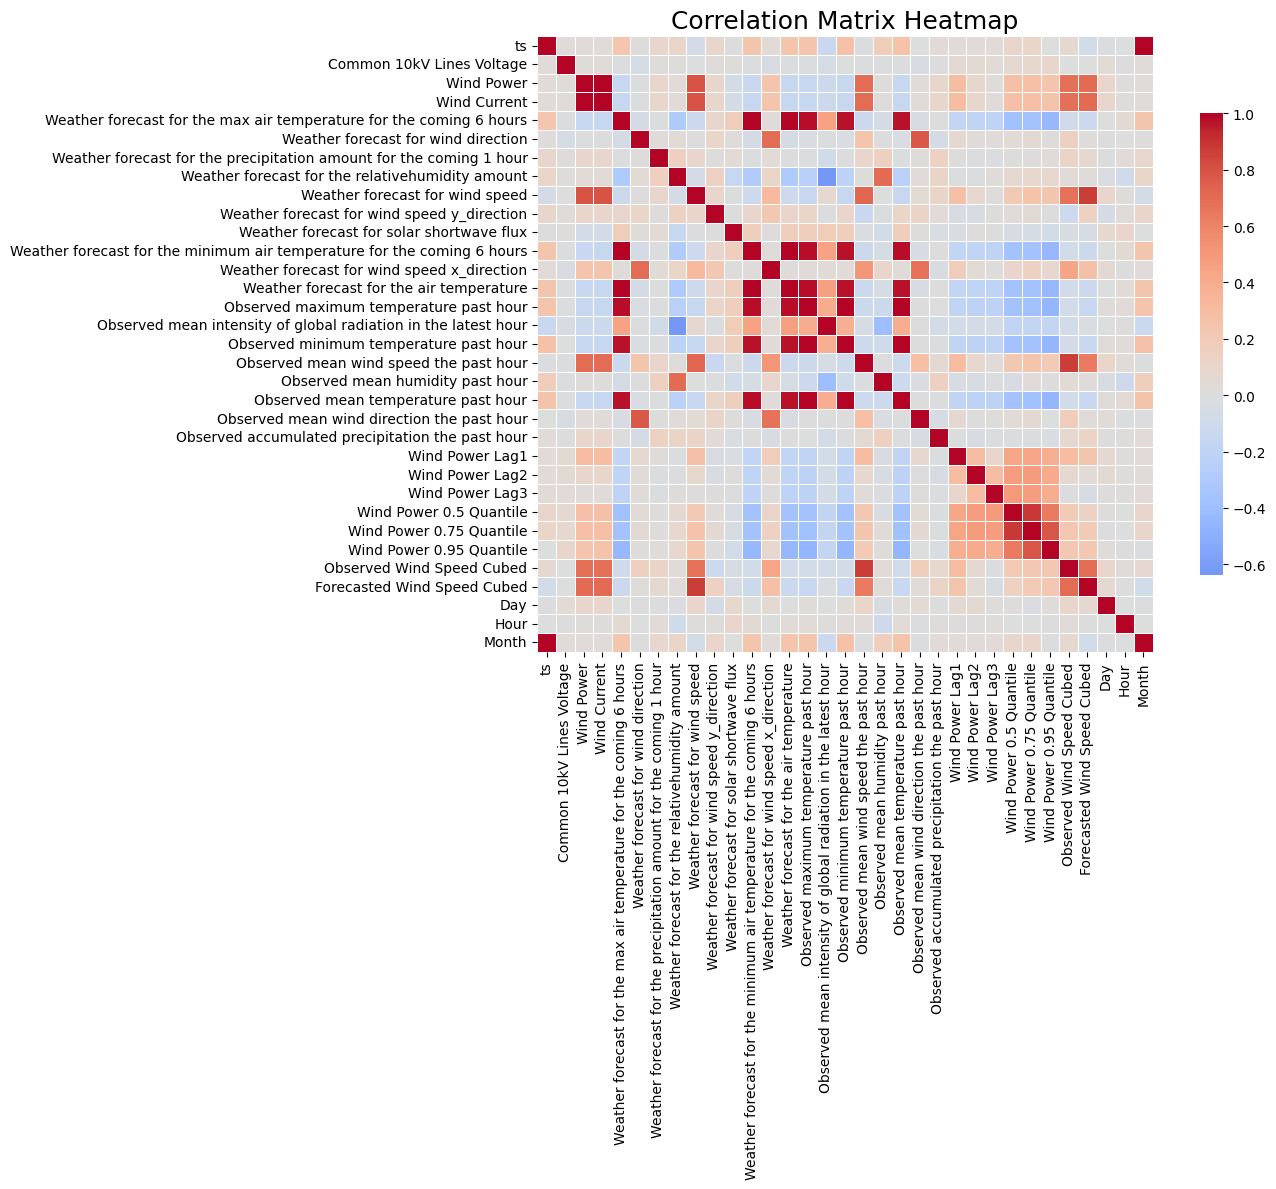

In [22]:
# Correlation matrix between features
corr_matrix = data.corr()
# print(corr_matrix)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={"shrink": 0.75}, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

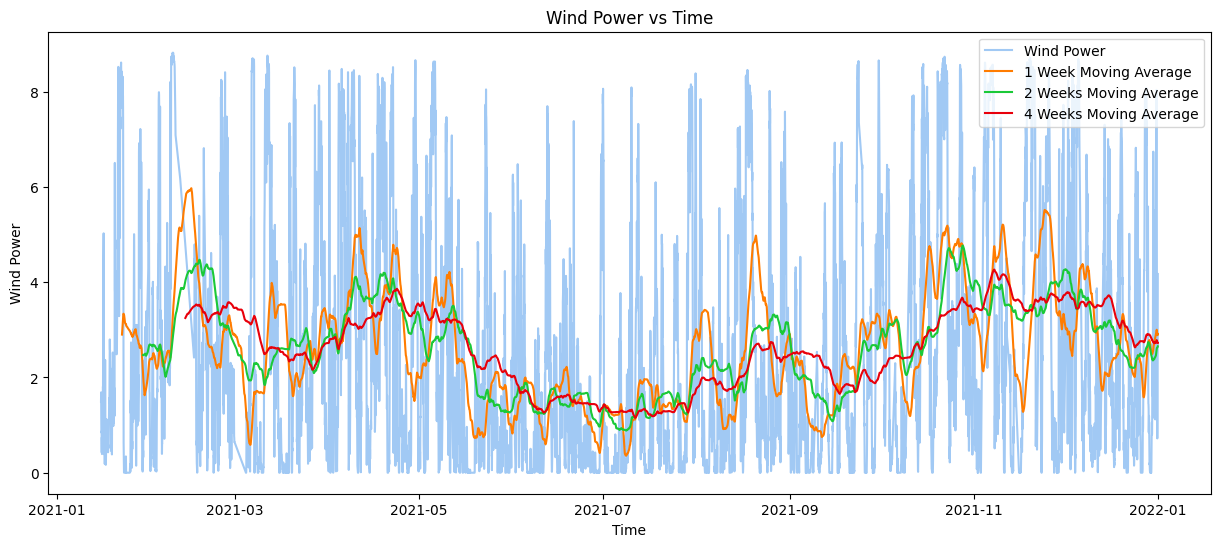

In [25]:
palette1 = sns.color_palette("pastel")
palette2 = sns.color_palette("bright")

# Plot moving average of wind power vs time
plt.figure(figsize=(15, 6))
sns.lineplot(x=data['ts'], y=data['Wind Power'], label='Wind Power', color=palette1[0])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=168).mean(), label='1 Week Moving Average', color=palette2[1])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=336).mean(), label='2 Weeks Moving Average', color=palette2[2])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=672).mean(), label='4 Weeks Moving Average', color=palette2[3])
plt.title('Wind Power vs Time')
plt.xlabel('Time')
plt.ylabel('Wind Power')
plt.legend(loc='upper right')
plt.show()

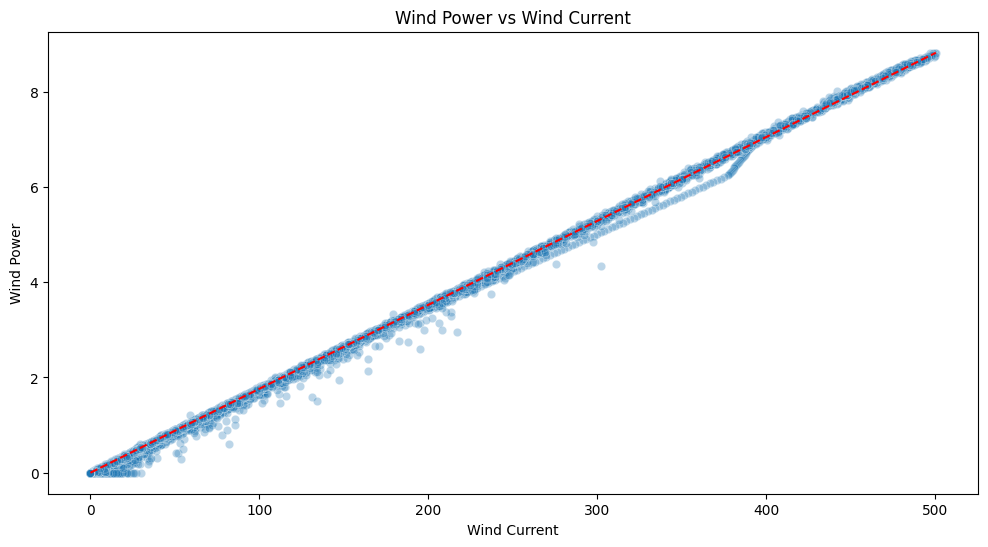

In [26]:
# Plot wind power vs wind current
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Wind Current', y='Wind Power', data=data, alpha=0.3)
plt.plot([0, data['Wind Current'].max()], [0, data['Wind Power'].max()], color='red', linestyle='--')
plt.title('Wind Power vs Wind Current')
plt.xlabel('Wind Current')
plt.ylabel('Wind Power')
plt.show()

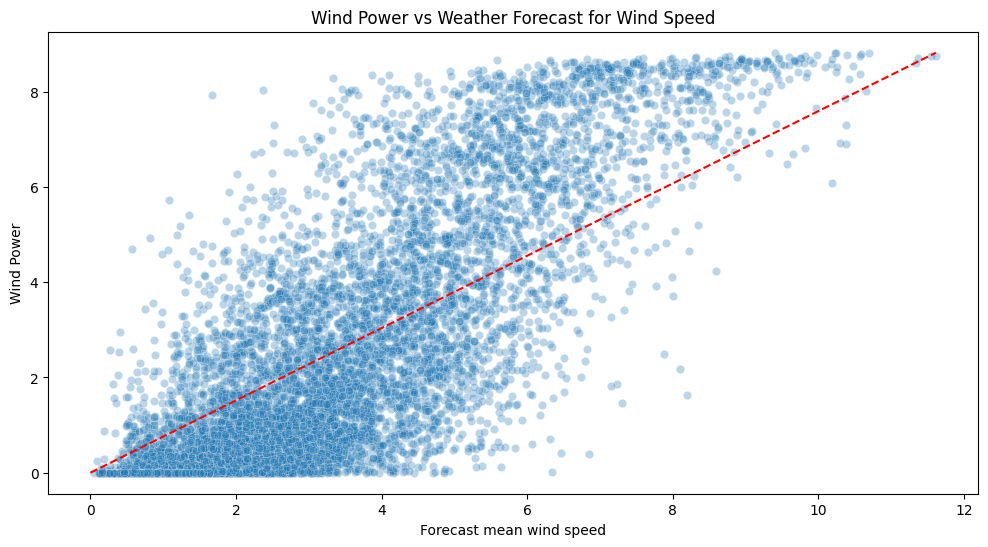

In [27]:
# Plot wind power vs weather forecast for wind speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Weather forecast for wind speed', y='Wind Power', data=data, alpha=0.3)
plt.plot([0, data['Weather forecast for wind speed'].max()], [0, data['Wind Power'].max()], color='red', linestyle='--')
plt.title('Wind Power vs Weather Forecast for Wind Speed')
plt.xlabel('Forecast mean wind speed')
plt.ylabel('Wind Power')
plt.show()

## Step 3: Linear Regression

Split 80/20 train and test

In [65]:
# Define X, y
X = data.drop(columns=['ts', 'Wind Power', 'Wind Current']) # Features
ts = data['ts']
y = data['Wind Power']

# Split 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with original indices and column names
X_train = pd.DataFrame(X_train, index=X.index[:split_index], columns=X.columns)
X_test = pd.DataFrame(X_test, index=X.index[split_index:], columns=X.columns)
y_train = pd.Series(y_train.values, index=y.index[:split_index])
y_test = pd.Series(y_test.values, index=y.index[split_index:])

# Confirm index alignment
print("Train Index Equality:", X_train.index.equals(y_train.index))
print("Test Index Equality:", X_test.index.equals(y_test.index))

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Train Index Equality: True
Test Index Equality: True
Training data shape: (6726, 30)
Testing data shape: (1682, 30)


X including 'Wind Current‘ feature

In [115]:
# Define X2
X2 = data.drop(columns=['ts', 'Wind Power']) # Features

# Split 80/20
X_train2, X_test2 = X2[:split_index], X2[split_index:]

# Scale the features using StandardScaler
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# Convert scaled arrays back to DataFrames with original indices and column names
X_train2 = pd.DataFrame(X_train2, index=X2.index[:split_index], columns=X2.columns)
X_test2 = pd.DataFrame(X_test2, index=X2.index[split_index:], columns=X2.columns)

# Confirm index alignment
print("Train Index Equality:", X_train2.index.equals(y_train.index))
print("Test Index Equality:", X_test2.index.equals(y_test.index))

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train2.shape}")
print(f"Testing data shape: {X_test2.shape}")

Train Index Equality: True
Test Index Equality: True
Training data shape: (6726, 31)
Testing data shape: (1682, 31)


In [32]:
# # Define X, y
# X = data.drop(columns=['ts', 'Wind Power']) # Features
# ts = data['ts']
# y = data['Wind Power']

# # ts_test = ts_column[X_test.index] # if neccessary later

# # Scale the features using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# # Get shapes
# print("Train set:", X_train.shape)
# print("Test set:", X_test.shape)

# # Check indices
# X_train = pd.DataFrame(X_train)
# y_train = pd.Series(y_train)
# X_test = pd.DataFrame(X_test)
# y_test = pd.Series(y_test)

# print("Train Index Equality:", X_train.index.equals(y_train.index))
# print("Test Index Equality:", X_test.index.equals(y_test.index))

# # # Align indices
# # X_test = pd.DataFrame(X_test, columns=X.columns)
# # y_test = pd.Series(y_test.values, index=y_test.index)
# # X_test.index = y_test.index

# print("Test Index Equality (2):", X_test.index.equals(y_test.index))

In [40]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.1133118984666788
R-squared: 0.6982378452336567


### Step 3.1: Linear Regression (small sample)

Implementation of both approaches

In [57]:
# Step 3.1: Gradient Descent
class LinearRegressionGD:

    # attributes of the class
    def __init__(self, learning_rate=0.01, n_iterations=1000): 
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    # gradient descent algorithm
    def fit(self, X, y): 
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    # prediction function
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

################################################################################################################################################

# Step 3.1: Closed-form solution (Normal Equation)
def ClosedFormSolution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best

Test of both approaches on small sample (e.g. 200 rows)

In [62]:
# Small subset of train data
X_train_small = np.array(X_train[100:300], dtype=float)  
y_train_small = np.array(y_train[100:300], dtype=float)

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.001, n_iterations=1000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = ClosedFormSolution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

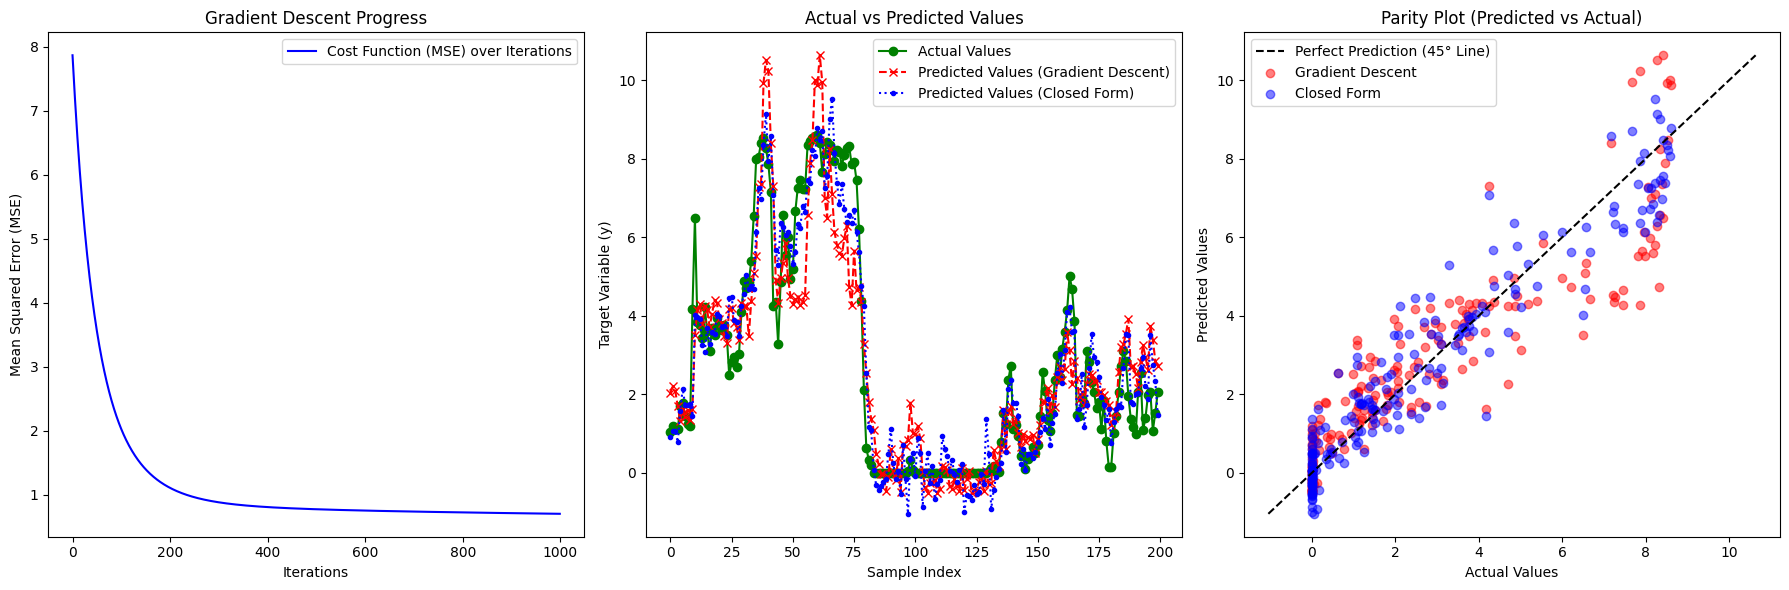

Gradient Descent Coefficients: [ 0.24294729 -0.02594506 -0.15823537  0.02787544  0.06141699 -0.02029686
  0.6129494   0.49715185 -0.02524686 -0.16148116  0.24586751 -0.15713772
 -0.15679418 -0.15541572 -0.14715074  0.46298402 -0.20236432 -0.15247366
  0.04808649  0.01165407  0.20294041 -0.09902755 -0.21305715 -0.01463771
 -0.06634508  0.05402906  0.31149767  0.44551078  0.10521219 -0.02157318
 -0.4177904 ]
Closed-Form Solution Coefficients: [ 0.89310584 -2.73327885  0.32125124  0.20921538  0.06068721 -0.60682352
  1.01559099  0.359773   -0.05193103 -1.4200231  -0.59329391  4.62393727
 -5.472462   -1.68075581  1.14012667  0.46877553 -0.62775447  1.82724981
 -0.0982918   0.23322335 -0.02496805 -0.11928217 -0.10121712  1.41987168
 -2.46543655  1.29867799  1.06084772 -0.34884663  0.13812769 -0.18575417
 -1.53585184]
Are the predictions close?  False


In [63]:
# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train_small, label='Actual Values', marker='o', color='g')
axs[1].plot(y_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
# print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form, atol=1e-1))

### Step 3.2: Linear Regression (large sample)

In [86]:
# Closed-Form Solution (Normal Equation)
theta_best_full = ClosedFormSolution(X_train, y_train) # Compute on the train data
X_b_full = np.c_[np.ones((X_test.shape[0], 1)), X_test] # Predictions on the test / unseen data!
y_test_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.00001, n_iterations=500000)  
gd_model.fit(X_train, y_train) # Compute on the train data
y_test_pred_gd = gd_model.predict(X_test) # Predictions on the test / unseen data!

# Convert predictions to pandas Series with y_test's original index
y_test_pred_closed_form = pd.Series(y_test_pred_closed_form, index=y_test.index)
y_test_pred_gd = pd.Series(y_test_pred_gd, index=y_test.index)

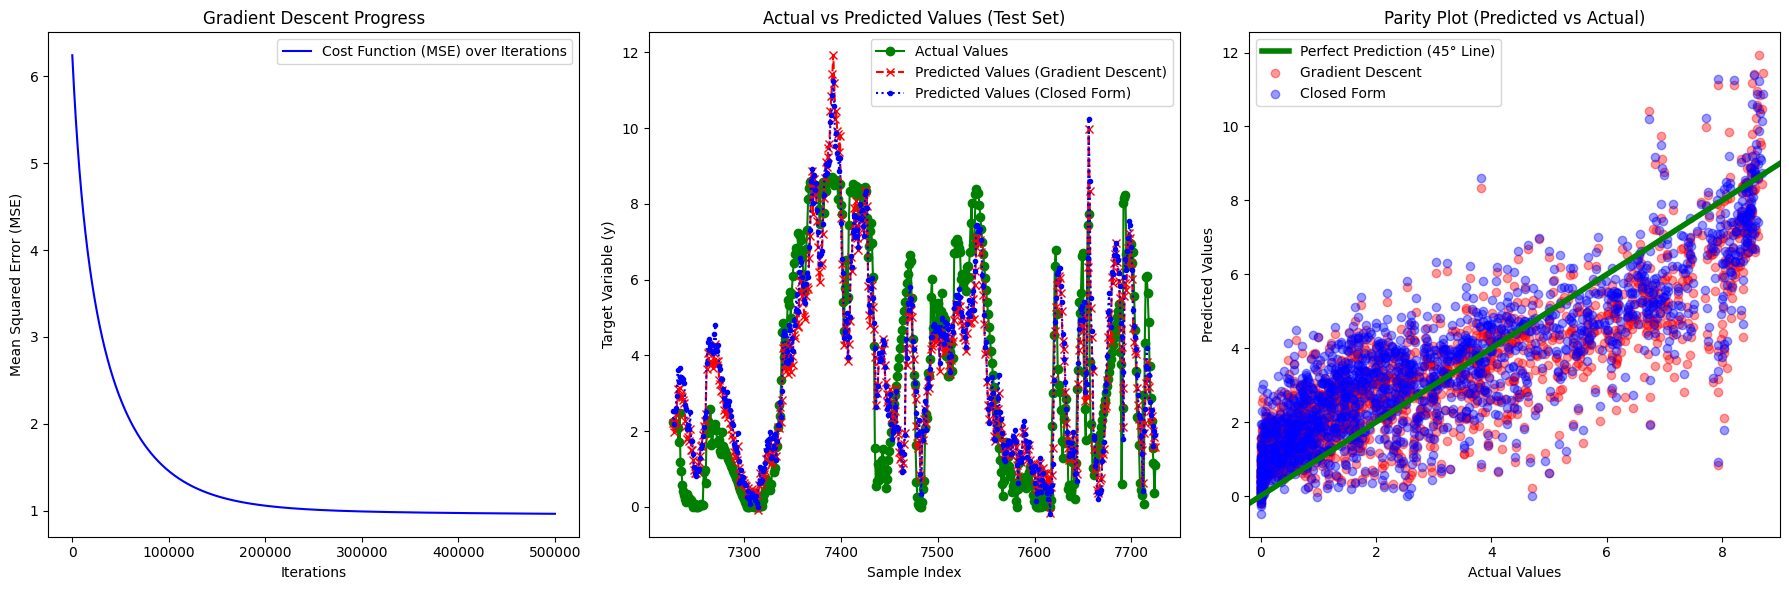

Gradient Descent Coefficients: [ 2.45299767e+00  1.11628079e-02  8.25426628e-03 -1.66725674e-01
  9.39461080e-03  5.12449369e-02  1.01557716e+00  2.22902742e-01
 -9.38278061e-02  1.43923029e-02 -1.35026438e-01  3.05205612e-03
  1.02166342e-03 -2.53219225e-01  4.60303763e-03  5.43749294e-01
 -1.06875183e-01  3.23093212e-03 -7.71685231e-02 -2.34725788e-02
  8.18688291e-02 -3.77746076e-02 -8.35362602e-02  2.32823073e-01
  9.92551098e-03 -8.05976299e-03  3.42491037e-01  3.13624651e-01
  6.22871643e-02  2.26920948e-02  8.57285769e-02]
Closed-Form Solution Coefficients: [ 2.46963754  0.01078714  0.62965855 -0.095115   -0.01748475  0.15574828
  1.58745547  0.22330172 -0.10439333 -0.03250548 -0.23626408 -0.34963249
  0.03203919 -0.31243576 -0.36671637  0.3833017  -0.18167798  0.12991827
 -0.0195759  -0.0394701   0.07002859 -0.04222947 -0.08673089  0.296935
 -0.1311695   0.05130275  0.44081859 -0.14769141  0.04580317  0.02036174
  0.13861852]
Are the predictions close?  False


In [128]:
# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_test[500:1000], label='Actual Values', marker='o', color='g')
axs[1].plot(y_test_pred_gd[500:1000], label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_test_pred_closed_form[500:1000], label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Test Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_test.min(), y_test_pred_gd.min(), y_test_pred_closed_form.min())
max_val = max(y_test.max(), y_test_pred_gd.max(), y_test_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction (45° Line)', linestyle='-', linewidth=4 ,color='g')
# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_test, y_test_pred_gd, label='Gradient Descent', color='r', alpha=0.4)
# Scatter plot for Closed-Form predictions
axs[2].scatter(y_test, y_test_pred_closed_form, label='Closed Form', color='b', alpha=0.4)

axs[2].set_xlim(-0.2,9)
axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_test_pred_gd, y_test_pred_closed_form))

In [118]:
# Step 3.3: Evaluate the models 
rmse_gd = np.sqrt(mean_squared_error(y_test, y_test_pred_gd))
r2_gd = r2_score(y_test, y_test_pred_gd)
print(f'Mean Squared Error (Gradient Descent): {rmse_gd}')
print(f'R-squared (Gradient Descent): {r2_gd}')

rmse_closed_form = np.sqrt(mean_squared_error(y_test, y_test_pred_closed_form))
r2_closed_form = r2_score(y_test, y_test_pred_closed_form)
print(f'Mean Squared Error (Closed Form): {rmse_closed_form}')
print(f'R-squared (Closed Form): {r2_closed_form}')


Mean Squared Error (Gradient Descent): 1.4483177152220474
R-squared (Gradient Descent): 0.700477908529952
Mean Squared Error (Closed Form): 1.4537234601073956
R-squared (Closed Form): 0.6982378452336654


In [119]:
# Get coefficients from the Linear Regression model
cols = ['Intercept'] + list(X_train.columns)
lr_coefficients_df = pd.DataFrame({ 'Feature': cols, 'Coefficient (GD)': gd_model.theta, 'Coefficient (Closed Form)': theta_best_full})
lr_coefficients_df.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Feature,Intercept,Common 10kV Lines Voltage,Weather forecast for the max air temperature f...,Weather forecast for wind direction,Weather forecast for the precipitation amount ...,Weather forecast for the relativehumidity amount,Weather forecast for wind speed,Weather forecast for wind speed y_direction,Weather forecast for solar shortwave flux,Weather forecast for the minimum air temperatu...,...,Wind Power Lag2,Wind Power Lag3,Wind Power 0.5 Quantile,Wind Power 0.75 Quantile,Wind Power 0.95 Quantile,Observed Wind Speed Cubed,Forecasted Wind Speed Cubed,Day,Hour,Month
Coefficient (GD),2.452998,0.011163,0.008254,-0.166726,0.009395,0.051245,1.015577,0.222903,-0.093828,0.014392,...,-0.037775,-0.083536,0.232823,0.009926,-0.00806,0.342491,0.313625,0.062287,0.022692,0.085729
Coefficient (Closed Form),2.469638,0.010787,0.629659,-0.095115,-0.017485,0.155748,1.587455,0.223302,-0.104393,-0.032505,...,-0.042229,-0.086731,0.296935,-0.131169,0.051303,0.440819,-0.147691,0.045803,0.020362,0.138619


In [93]:
# # Step 3.3: Evaluate the model on the testing dataset
# X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
# y_test_pred = X_b_test.dot(theta_best_full)

# # Evaluation Metrics
# rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# mae = mean_absolute_error(y_test, y_test_pred)
# r2 = r2_score(y_test, y_test_pred)

# print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R²): {r2}")

### Step 3.3: Linear Regression (large sample + Wind Current)

In [120]:
# Closed-Form Solution (Normal Equation)
theta_best_full2 = ClosedFormSolution(X_train2, y_train) # Compute on the train data
X_b_full2 = np.c_[np.ones((X_test.shape[0], 1)), X_test2] # Predictions on the test / unseen data!
y_test_pred_closed_form2 = X_b_full2.dot(theta_best_full2)

# Train using Gradient Descent on full dataset
gd_model2 = LinearRegressionGD(learning_rate=0.00001, n_iterations=500000)  
gd_model2.fit(X_train2, y_train) # Compute on the train data
y_test_pred_gd2 = gd_model2.predict(X_test2) # Predictions on the test / unseen data!

# Convert predictions to pandas Series with y_test's original index
y_test_pred_closed_form2 = pd.Series(y_test_pred_closed_form2, index=y_test.index)
y_test_pred_gd2 = pd.Series(y_test_pred_gd2, index=y_test.index)

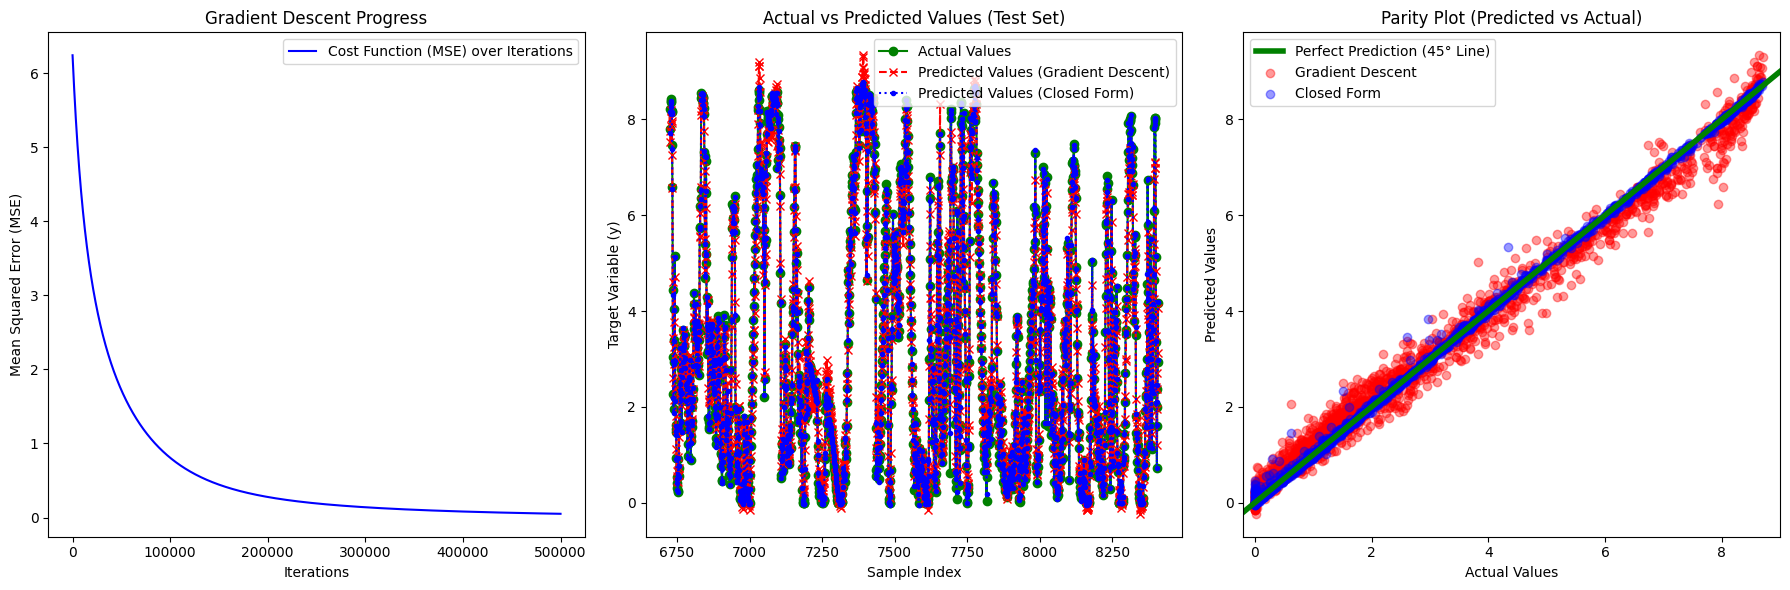

Gradient Descent Coefficients: [ 2.45299767e+00  2.73235951e-04  1.96187218e+00  6.30583327e-03
 -3.44700118e-02 -4.58630220e-03  2.07887424e-02  3.26280052e-01
  6.97563144e-02 -2.81899712e-02  7.81731162e-03 -6.38958705e-02
  3.48808284e-03  6.57937468e-04 -8.79162646e-02  2.50381267e-03
  1.45217197e-01 -3.72506885e-02  1.74526467e-03 -6.48931928e-03
 -1.84246734e-02  7.50848634e-03 -1.39678755e-02 -2.35464902e-02
  7.06891232e-02 -1.19663805e-02 -9.32867943e-03  6.23369505e-02
  2.46106380e-02  1.11362838e-02  6.22500066e-03  3.27636572e-02]
Closed-Form Solution Coefficients: [ 2.46963754e+00 -1.79270425e-03  2.52378202e+00  7.74451481e-03
  4.09518764e-03 -4.04499550e-04  1.78601504e-03  6.33523484e-03
  8.61527578e-03 -1.25743994e-03 -1.96689326e-03 -2.81217463e-03
 -1.63375539e-02 -7.86907007e-02  3.34714736e-03  1.01698475e-01
 -2.72270040e-03  1.06230842e-03 -1.53408722e-02  1.89509175e-03
 -2.55955142e-03 -3.50251315e-03 -3.68068018e-03 -4.80874726e-03
 -1.89596425e-02  1.828

In [127]:
# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model2.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_test, label='Actual Values', marker='o', color='g')
axs[1].plot(y_test_pred_gd2, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_test_pred_closed_form2, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Test Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_test.min(), y_test_pred_gd2.min(), y_test_pred_closed_form2.min())
max_val = max(y_test.max(), y_test_pred_gd2.max(), y_test_pred_closed_form2.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction (45° Line)', linestyle='-', linewidth=4 ,color='g')
# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_test, y_test_pred_gd2, label='Gradient Descent', color='r', alpha=0.4)
# Scatter plot for Closed-Form predictions
axs[2].scatter(y_test, y_test_pred_closed_form2, label='Closed Form', color='b', alpha=0.4)

axs[2].set_xlim(-0.2,9)
axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model2.theta)
print("Closed-Form Solution Coefficients:", theta_best_full2)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_test_pred_gd2, y_test_pred_closed_form2))

In [125]:
# Step 3.3: Evaluate the models 
rmse_gd2 = np.sqrt(mean_squared_error(y_test, y_test_pred_gd2))
r2_gd2 = r2_score(y_test, y_test_pred_gd2)
print(f'Mean Squared Error (Gradient Descent): {rmse_gd2}')
print(f'R-squared (Gradient Descent): {r2_gd2}')

rmse_closed_form2 = np.sqrt(mean_squared_error(y_test, y_test_pred_closed_form2))
r2_closed_form2 = r2_score(y_test, y_test_pred_closed_form2)
print(f'Mean Squared Error (Closed Form): {rmse_closed_form2}')
print(f'R-squared (Closed Form): {r2_closed_form2}')

Mean Squared Error (Gradient Descent): 0.3305467979200987
R-squared (Gradient Descent): 0.9843984738705633
Mean Squared Error (Closed Form): 0.07818943439210982
R-squared (Closed Form): 0.9991270340245925


In [126]:
# Get coefficients from the Linear Regression model
cols = ['Intercept'] + list(X_train2.columns)
lr_coefficients_df2 = pd.DataFrame({ 'Feature': cols, 'Coefficient (GD)': gd_model2.theta, 'Coefficient (Closed Form)': theta_best_full2})
lr_coefficients_df2.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Feature,Intercept,Common 10kV Lines Voltage,Wind Current,Weather forecast for the max air temperature f...,Weather forecast for wind direction,Weather forecast for the precipitation amount ...,Weather forecast for the relativehumidity amount,Weather forecast for wind speed,Weather forecast for wind speed y_direction,Weather forecast for solar shortwave flux,...,Wind Power Lag2,Wind Power Lag3,Wind Power 0.5 Quantile,Wind Power 0.75 Quantile,Wind Power 0.95 Quantile,Observed Wind Speed Cubed,Forecasted Wind Speed Cubed,Day,Hour,Month
Coefficient (GD),2.452998,0.000273,1.961872,0.006306,-0.03447,-0.004586,0.020789,0.32628,0.069756,-0.02819,...,-0.013968,-0.023546,0.070689,-0.011966,-0.009329,0.062337,0.024611,0.011136,0.006225,0.032764
Coefficient (Closed Form),2.469638,-0.001793,2.523782,0.007745,0.004095,-0.000404,0.001786,0.006335,0.008615,-0.001257,...,-0.003681,-0.004809,-0.01896,0.018286,-0.000636,0.006652,-0.005501,-0.000292,0.000701,0.006443


## Step 4: Non-linear Regression

In [215]:
# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train.shape[0])  # Random weights for demonstration -> how to set up 
model_weighted = LinearRegression()
model_weighted.fit(X_train, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train)

# Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_gd))
mae_linear = mean_absolute_error(y_train, y_train_pred_gd)
r2_linear = r2_score(y_train, y_train_pred_gd)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

rmse_weighted = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
mae_weighted = mean_absolute_error(y_train, y_train_pred_weighted)
r2_weighted = r2_score(y_train, y_train_pred_weighted)

print(f"Linear Model RMSE: {rmse_linear}")
print(f"Polynomial Model RMSE: {rmse_poly}")
print(f"Weighted Model RMSE: {rmse_weighted}")


Linear Model RMSE: 0.15948912743085453
Polynomial Model RMSE: 0.056583928120689395
Weighted Model RMSE: 0.06794983685337698


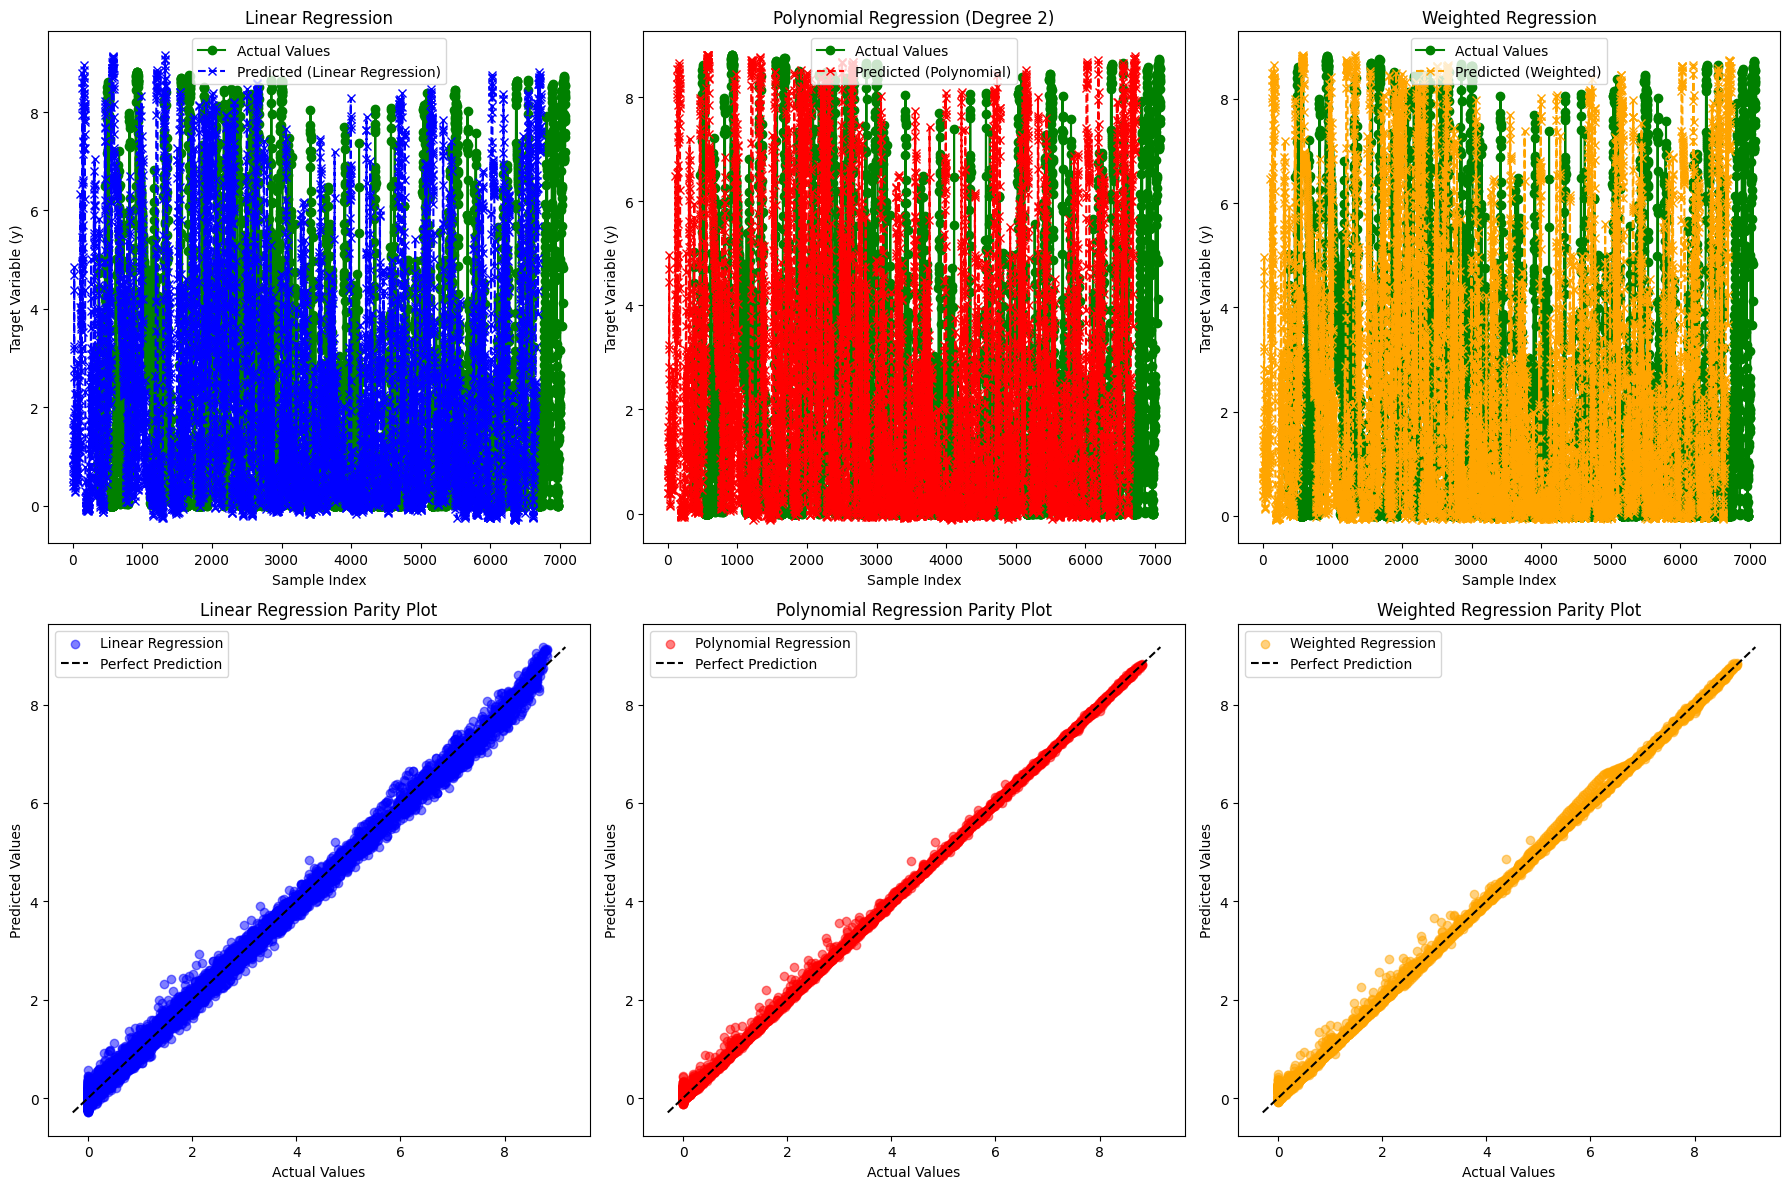

In [216]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_train_pred_gd, label='Predicted (Linear Regression)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_train_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_train_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_train, y_train_pred_gd, color='b', alpha=0.5, label='Linear Regression')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_train, y_train_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_train, y_train_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Step 5: Lasso + Ridge Regression

##### Lasso + Ridge (Package)

In [155]:
# Initialize Lasso with alpha (regularization strength) parameter 
lasso = Lasso(alpha=0.1)
lasso.fit(X_train2, y_train) # including Wind Current
y_pred_lasso = lasso.predict(X_test2)

# Evaluate the Lasso model
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared (R²): {r2_lasso}")

# Get coefficients (non-zero ones indicate selected features)
print("#Lasso Coefficients != 0:", np.sum(lasso.coef_ != 0))
print("Lasso Coefficients:", lasso.coef_)

Root Mean Squared Error (RMSE): 0.1430198393584183
R-squared (R²): 0.9970792543014654
#Lasso Coefficients != 0: 1
Lasso Coefficients: [ 0.          2.42550701 -0.          0.          0.          0.
  0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


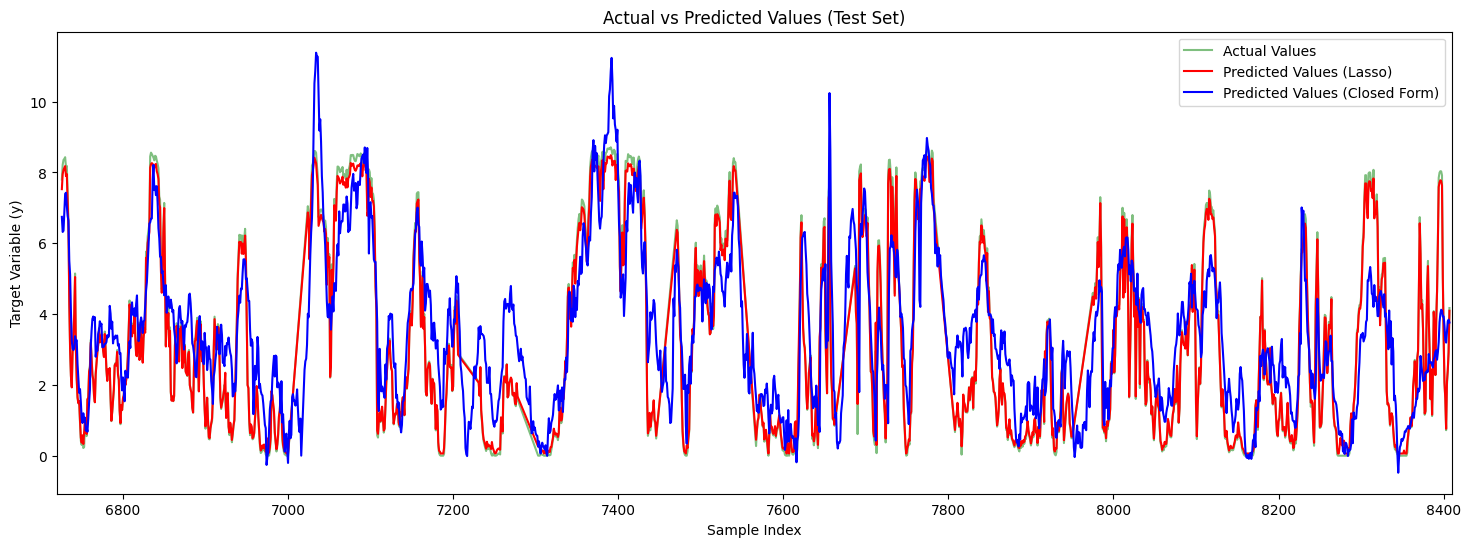

In [156]:
# Convert predictions to pandas Series with y_test's original index
y_pred_lasso = pd.Series(y_pred_lasso, index=y_test.index)

# Plot
plt.figure(figsize=(18, 6))
plt.plot(y_test, label='Actual Values', color='g', alpha=0.5)
plt.plot(y_pred_lasso, label='Predicted Values (Lasso)', color='r') # linestyle='--',
plt.plot(y_test_pred_closed_form, label='Predicted Values (Closed Form)', color='b') # linestyle=':',
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (y)')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.xlim(6720, 8410)
plt.show()

LASSO with Cross-Validation to select optimal alpha value

In [130]:
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 0, num=20)

# Set up the Lasso model with CV
lasso2 = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(estimator=lasso2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.934e+01, tolerance: 3.298e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.571e+02, tolerance: 3.236e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal Alpha: 0.05455594781168514


In [132]:
# Lasso Model
lasso3 = Lasso(alpha=best_alpha)
lasso3.fit(X_train, y_train)
y_pred_lasso = lasso3.predict(X_test)

# Evaluate Lasso model
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared (R²): {r2_lasso}")

# Coefficients
print("#Lasso Coefficients != 0:", np.sum(lasso3.coef_ != 0))
lasso_coefficients_df = pd.DataFrame({ 'Feature': X_train.columns, 'Coefficient': lasso3.coef_}) 
lasso_coefficients_df = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0] # Filter non-zeros
lasso_coefficients_df.T

Root Mean Squared Error (RMSE): 1.4306723338468321
R-squared (R²): 0.707731822273935
#Lasso Coefficients != 0: 13


,2,5,6,7,9,12,14,15,19,21,22,25,29
Feature,Weather forecast for wind direction,Weather forecast for wind speed,Weather forecast for wind speed y_direction,Weather forecast for solar shortwave flux,Weather forecast for wind speed x_direction,Observed mean intensity of global radiation in...,Observed mean wind speed the past hour,Observed mean humidity past hour,Wind Power Lag1,Wind Power Lag3,Wind Power 0.5 Quantile,Observed Wind Speed Cubed,Month
Coefficient,-0.135495,1.447143,0.142005,-0.038651,-0.083871,-0.268034,0.299174,-0.03088,0.038924,-0.01793,0.135171,0.404057,0.047733


RIDGE

In [251]:
from sklearn.linear_model import Ridge

# Build Ridge model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_train)

# Evaluate Ridge model
rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_pred))
mae_ridge = mean_absolute_error(y_test_reg, y_pred)
r2_ridge = r2_score(y_test_reg, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"R-squared (R²): {r2_ridge}")

# Coefficients
print("#Ridge Coefficients != 0:", np.sum(ridge.coef_ != 0))
# Save coefficients
theta_best_ridge = np.append(ridge.intercept_, ridge.coef_)
ridge_coefficients_df = pd.DataFrame({ 'Feature': X_train_reg.columns, 'Coefficient': ridge.coef_})
ridge_coefficients_df = ridge_coefficients_df[ridge_coefficients_df['Coefficient'] != 0] # Filter non-zeros
ridge_coefficients_df.T

Root Mean Squared Error (RMSE): 1.4653428576900185
Mean Absolute Error (MAE): 1.181844889114298
R-squared (R²): 0.6933946860003182
#Ridge Coefficients != 0: 29


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
Feature,Common 10kV Lines Voltage,Weather forecast for the max air temperature f...,Weather forecast for wind direction,Weather forecast for the precipitation amount ...,Weather forecast for the relativehumidity amount,Weather forecast for wind speed,Weather forecast for wind speed y_direction,Weather forecast for solar shortwave flux,Weather forecast for the minimum air temperatu...,Weather forecast for wind speed x_direction,Weather forecast for the air temperature,Observed maximum temperature past hour,Observed mean intensity of global radiation in...,Observed minimum temperature past hour,Observed mean wind speed the past hour,Observed mean humidity past hour,Observed mean temperature past hour,Observed mean wind direction the past hour,Observed accumulated precipitation the past hour,Wind Power Lag1,Wind Power Lag2,Wind Power Lag3,Wind Power 0.05 Quantile,Wind Power 0.5 Quantile,Wind Power 0.95 Quantile,Observed Wind Speed Cubed,Day,Hour,Month
Coefficient,0.016315,0.084798,-0.001059,-0.005736,1.086066,0.725708,0.090506,-0.0,0.00338,-0.077049,-0.044939,0.011583,-0.001332,-0.048839,0.123595,-0.016795,-0.002514,-0.000285,-0.083488,0.026713,-0.0181,-0.036825,0.341006,0.111829,0.011104,0.000504,0.027285,0.002867,0.058206


In [234]:
def ridge_closed_form_solution(X, y, alpha=1.0):
    # Ensure X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]

    # Normal equation: theta = (X.T * X + alpha * I)^(-1) * X.T * y
    identity_matrix = np.eye(X_b.shape[1])
    theta_best = np.linalg.inv(X_b.T.dot(X_b) + alpha * identity_matrix).dot(X_b.T).dot(y)

    return theta_best

### Step 5.1: Linear Regression with Regularization

In [161]:
from sklearn.base import BaseEstimator, RegressorMixin

class LinearRegressionWithRegularization(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, alpha=0.1, regularization="l1"):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.alpha = alpha  # Regularization strength
        self.regularization = regularization
        self.theta = None  # Parameters (weights and bias)

    def fit(self, X, y):
        # Ensure X and y are NumPy arrays
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # X_b now includes the bias term
        m, n = X_b.shape

        # Initialize theta
        self.theta = np.zeros(n)

        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)

            # Compute the gradient
            gradient = (1 / m) * X_b.T.dot(y_pred - y)

            # Apply regularization to the gradient (skip bias term)
            if self.regularization == "l2":
                # L2 Regularization (Ridge): (MSE + L2 penalty)
                gradient[1:] += 2 * self.alpha * self.theta[1:]
            elif self.regularization == "l1":
                # L1 Regularization (LASSO): (MSE + L1 penalty)
                for j in range(1, n):
                    if self.theta[j] > 0:
                        gradient[j] += self.alpha
                    elif self.theta[j] < 0:
                        gradient[j] -= self.alpha

            # Update parameters
            self.theta -= self.learning_rate * gradient

    def predict(self, X):
        # Ensure X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

In [166]:
# Test model
model_l1 = LinearRegressionWithRegularization(alpha=0.05, regularization="l1")
model_l1.fit(X_train, y_train)
y_pred_l1 = model_l1.predict(X_test)

# Evaluate L1 model
r2_l1 = r2_score(y_test, y_pred_l1)
print(f"R-squared (R²): {r2_l1}")

R-squared (R²): 0.7071765173056228


In [165]:
# Initialize the model
model_lasso = LinearRegressionWithRegularization(regularization="l1", learning_rate=0.001, n_iterations=10000)
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 0, num=20)
param_grid = {'alpha': alpha_values}

# Set up the Lasso model with CV
grid_search = GridSearchCV(estimator=model_lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

# Best model after grid search
best_model = grid_search.best_estimator_
y_pred_l1 = best_model.predict(X_test)

# Evaluate the model
r2_l1 = r2_score(y_test, y_pred_l1)

# Coefficients
print("#Lasso Coefficients != 0:", np.sum(best_model.theta != 0))
cols = ['Intercept'] + list(X_train.columns)
lasso_coefficients_df = pd.DataFrame({ 'Feature': cols, 'Coefficient': best_model.theta})
lasso_coefficients_df = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0] # Filter non-zeros
lasso_coefficients_df.T

Optimal Alpha: 0.05455594781168514
#Lasso Coefficients != 0: 31


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Feature,Intercept,Common 10kV Lines Voltage,Weather forecast for the max air temperature f...,Weather forecast for wind direction,Weather forecast for the precipitation amount ...,Weather forecast for the relativehumidity amount,Weather forecast for wind speed,Weather forecast for wind speed y_direction,Weather forecast for solar shortwave flux,Weather forecast for the minimum air temperatu...,...,Wind Power Lag2,Wind Power Lag3,Wind Power 0.5 Quantile,Wind Power 0.75 Quantile,Wind Power 0.95 Quantile,Observed Wind Speed Cubed,Forecasted Wind Speed Cubed,Day,Hour,Month
Coefficient,2.469526,-0.000009,0.000012,-0.157392,0.000023,-0.000011,1.217225,0.158919,-0.037953,-0.000021,...,-0.000028,-0.022255,0.157071,0.000057,0.000004,0.315131,0.147324,0.001946,0.000001,0.041595


### Step 5.2: Non-Linear Regression with Regularization

In [257]:
class PolynomialRegressionWithRegularization:
    def __init__(self, degree, learning_rate=0.01, n_iterations=1000, alpha=0.1, regularization="l1"):
        # Hyperparameters
        self.degree = degree
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.alpha = alpha # = Regularization strength
        self.regularization = regularization
        self.theta = None

    def _polynomial_features(self, X):
        # Generate polynomial features up to specified degree
        X_poly = np.ones((X.shape[0], 1)) # Bias term
        for d in range(1, self.degree + 1):
            X_poly = np.c_[X_poly, X ** d]
        return X_poly

    # Gradient Descent Fit
    def fit(self, X, y):
        # Generate polynomial features
        X_poly = self._polynomial_features(X)
        # Number of training samples (m) and number of features (n)
        m, n = X_poly.shape
        # Initialize theta
        self.theta = np.zeros(n)
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_poly.dot(self.theta)
            
            # Compute the gradient
            gradient = (1 / m) * X_poly.T.dot(y_pred - y)
            
            # Apply regularization to the gradient (& skip bias term)
            if self.regularization == "l2":
                # L2 Regularization (Ridge): (MSE + L2 penalty)
                gradient[1:] += 2 * self.alpha * self.theta[1:]
            elif self.regularization == "l1":
                # L1 Regularization (LASSO): (MSE + L1 penalty)
                for j in range(1, n):
                    if self.theta[j] > 0:
                        gradient[j] += self.alpha
                    elif self.theta[j] < 0:
                        gradient[j] -= self.alpha
            
            # Update parameters
            self.theta -= self.learning_rate * gradient
    
    def predict(self, X):
        # Generate polynomial features (including bias term)
        X_poly = self._polynomial_features(X)
        
        # Return predictions
        return X_poly.dot(self.theta)

## Step 6: Revenue Calculation